In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

In [4]:
!ls gdrive/MyDrive/data_image

california_wildfires  hurricane_irma   iraq_iran_earthquake  srilanka_floods
hurricane_harvey      hurricane_maria  mexico_earthquake


In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import transformers
from transformers import get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/Models/train.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [3]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.resnet = torchvision.models.resnet18(pretrained=True)
    # for param in self.resnet.parameters():
    #   param.requires_grad = False

    self.linear1 = nn.Linear(1000, 256)
    self.relu    = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, tweet_img):
    output = self.resnet(tweet_img)
    linear1_output = self.linear1(output)
    relu_output = self.relu(linear1_output)
    dropout_output = self.dropout(relu_output)
    linear2_output = self.linear2(dropout_output)
    probas = self.sigmoid(linear2_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [4]:
BATCH_SIZE = 512

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 40

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [9]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

checkpoint = torch.load("./gdrive/MyDrive/Models/ResNet/checkpoint.t7")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']

print(start_epoch)


# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     state = {
#             'best_accuracy': val_acc,
#             'epoch': start_epoch+epoch+1,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#     }
#     savepath= "./gdrive/MyDrive/Models/ResNet/checkpoint.t7"
#     torch.save(state,savepath)
#     best_accuracy = val_acc

34


In [6]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/ResNet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

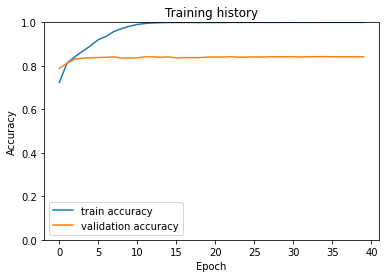

In [7]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [10]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative']))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative       0.78      0.75      0.77       504
    Informative       0.88      0.90      0.89      1030

       accuracy                           0.85      1534
      macro avg       0.83      0.82      0.83      1534
   weighted avg       0.85      0.85      0.85      1534

